In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x

In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.datasets import mnist
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import h5py
from skimage.transform import resize
from skimage.color import gray2rgb
from numpy import load
from numpy import save

batch_size = 128
num_classes = 10
num_epochs = 50
val_size = 5000
loadModelBool = False
saveModelBool = True

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def load_svhn_data(path, val_size, num_classes):
    with h5py.File(path+'/train.hdf5', 'r') as f:
        shape = f["X"].shape
        x_train = f["X"][:shape[0]-val_size]
        y_train = f["Y"][:shape[0]-val_size].flatten()
        x_val = f["X"][shape[0]-val_size:]
        y_val = f["Y"][shape[0] - val_size:].flatten()

    with h5py.File(path+'/test.hdf5', 'r') as f:
        x_test = f["X"][:]
        y_test = f["Y"][:].flatten()

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def reshapeImages(images):
    images_redone = []
    for image in images:
        image = resize(image,(32,32))
        image = gray2rgb(image)
        images_redone.append(image)
    
    images = np.asarray(images_redone)
    images = images.reshape(images.shape[0], 32, 32, 3)
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
# the data, split between train and test sets
# The full `train` split and the full `test` split as two distinct datasets.
(x_train_svhn, y_train_svhn), (x_val_svhn, y_val_svhn), (x_test_svhn, y_test_svhn) = load_svhn_data('drive/My Drive/Data/svhn', val_size, num_classes)
(x_train_mnist_orig, y_train_mnist_orig), (x_test_mnist_orig, y_test_mnist_orig) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
nr_of_nrs = 30
x_train_ = x_train_mnist_orig[y_train_mnist_orig == 0][:nr_of_nrs]
y_train_ = y_train_mnist_orig[y_train_mnist_orig == 0][:nr_of_nrs]
for i in range(1, 10):
  x_train_nr = x_train_mnist_orig[y_train_mnist_orig == i][:nr_of_nrs]
  y_train_nr = y_train_mnist_orig[y_train_mnist_orig == i][:nr_of_nrs]
  x_train_ = np.vstack((x_train_, x_train_nr))
  y_train_ = np.hstack((y_train_, y_train_nr))

In [ ]:
x_val_mnist = reshapeImages(x_train_mnist_orig)[x_train_mnist_orig.shape[0]-5000:]
x_train_mnist = reshapeImages(x_train_)
x_test_mnist = reshapeImages(x_test_mnist_orig)

# convert class vectors to binary class matrices
y_val_mnist = keras.utils.to_categorical(y_train_mnist_orig, num_classes)[y_train_mnist_orig.shape[0]-5000:]
y_train_mnist = keras.utils.to_categorical(y_train_, num_classes)
y_test_mnist = keras.utils.to_categorical(y_test_mnist_orig, num_classes)

y_mnist_zeros = np.zeros((y_train_mnist.shape[0],1))
y_train_mnist_ = np.hstack((y_train_mnist, y_mnist_zeros))
y_svhn_ones = np.ones((y_train_svhn.shape[0],1))
y_train_svhn_ = np.hstack((y_train_svhn, y_svhn_ones))

60000 samples
300 samples
10000 samples


In [ ]:
y_train_mnist_ = y_train_mnist_.astype(dtype = float)
y_train_svhn_ = y_train_svhn_.astype(dtype = float)

In [ ]:
input1 = keras.layers.Input(shape=(32,32,3))
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(input1)
conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu')(conv1)
maxpool1 = keras.layers.MaxPooling2D((2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.1)(maxpool1)
conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(dropout1)
conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu')(conv3)
maxpool2 = keras.layers.MaxPooling2D((2, 2))(conv4)
flatten = keras.layers.Flatten()(maxpool2)
dense2 = keras.layers.Dense(512, activation='relu')(flatten)
output = keras.layers.Dense(num_classes, activation='softmax')(dense2)

model = keras.Model(inputs=input1, outputs=[dense2,output])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928 

In [ ]:
if loadModelBool:
  model = keras.models.load_model('drive/My Drive/saved_model/model_svhn300mnist') 
  train_accuracy = load('drive/My Drive/Data/train_accuracy_svhn300mnistt.npy').tolist()
  dist_losses = load('drive/My Drive/Data/dist_losses_svhn300mnist.npy').tolist()
  cross_entropy_losses = load('drive/My Drive/Data/cross_entropy_losses_svhn300mnist.npy').tolist()
  val_accuracy = load('drive/My Drive/Data/val_accuracy_svhn300mnist.npy').tolist()
else: 
  dist_losses = []
  train_accuracy = []
  cross_entropy_losses = []
  val_accuracy = []

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_train_mnist, x_train_svhn], axis=0), np.concatenate([y_train_mnist_,y_train_svhn_],axis=0)))
train_dataset = train_dataset.shuffle(buffer_size=200000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_svhn, y_val_svhn))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
def distance_loss(predictions, y, predictions_target, y_target, classes_y):
    def some_function(tensor):
      y_source = tensor[1]
      equal =  tf.math.equal(y_source, y_target)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_target, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    y_equal_source =  tf.math.equal(classes_y, tf.constant(1, dtype=tf.float32))
    y_equal_all_source = tf.reduce_all(y_equal_source, axis=1)
    predictions_source = tf.boolean_mask(predictions, y_equal_all_source)
    y_source = tf.boolean_mask(y, y_equal_all_source)
    d = tf.map_fn(some_function, (predictions_source,y_source), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_target, y_train_target, classes_y):

    with tf.GradientTape() as tape:   
      hidden_logits = model(x_batch, training=True)[0]
      hidden_logits_target = model(x_train_target, training=True)[0]
      loss_dist = distance_loss(hidden_logits, y_batch, hidden_logits_target, y_train_target, classes_y)
      logits = model(x_batch, training=True)[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.0005*loss_dist

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_dist, loss_cross

In [ ]:
for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch, y_batch) in train_dataset:
      
      classes_y = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,-1], [y_batch.shape[0],y_batch.shape[0]], [1,1]),dtype=tf.float32)
      y_batch_ = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,0], [y_batch.shape[0],-1], [1,1]),dtype=tf.float32)

      loss_value, loss_dist, loss_cross = train_step(model, optimizer, x_batch, y_batch_, tf.constant(x_train_mnist, dtype=tf.float32), tf.constant(y_train_mnist, dtype=tf.float32), classes_y)

      # Log every 250 batches.
      if step % 250 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Distance loss and cross entropy loss at step %s: %s  %s' % (step, float(loss_dist),float(loss_cross)))

      step +=1
    dist_losses.append(float(loss_dist))
    cross_entropy_losses.append(float(loss_cross))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))
    val_accuracy.append(float(val_acc))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Training loss (for one batch) at step 0: 1.648762583732605
Distance loss and cross entropy loss at step 0: 278.2198791503906  1.5096526145935059
Training loss (for one batch) at step 250: 1.5823614597320557
Distance loss and cross entropy loss at step 250: 135.7284393310547  1.5144972801208496
Training loss (for one batch) at step 500: 1.5898685455322266
Distance loss and cross entropy loss at step 500: 117.7019271850586  1.531017541885376
Training acc over epoch: 0.9475764632225037
Validation acc: 0.9157999753952026
Start of epoch 1
Training loss (for one batch) at step 0: 1.5850410461425781
Distance loss and cross entropy loss at step 0: 114.21340942382812  1.5279343128204346
Training loss (for one batch) at step 250: 1.5884590148925781
Distance loss and cross entropy loss at step 250: 108.56343078613281  1.534177303314209
Training loss (for one batch) at step 500: 1.6007940769195557
Distance loss and cross entropy loss at step 500: 103.52569580078125  1.549031257629

In [ ]:
if saveModelBool:
  model.save('drive/My Drive/saved_model/model_svhn300mnist') 
  save('drive/My Drive/Data/train_accuracy_svhn300mnistt.npy', train_accuracy)
  save('drive/My Drive/Data/dist_losses_svhn300mnist.npy', dist_losses)
  save('drive/My Drive/Data/cross_entropy_losses_svhn300mnist.npy', cross_entropy_losses)
  save('drive/My Drive/Data/val_accuracy_svhn300mnist.npy', val_accuracy)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/My Drive/saved_model/model_svhn300mnist/assets


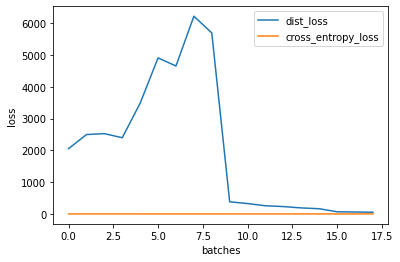

In [ ]:
plt.plot(dist_losses)
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['dist_loss', 'cross_entropy_loss'], loc='best')
plt.show()

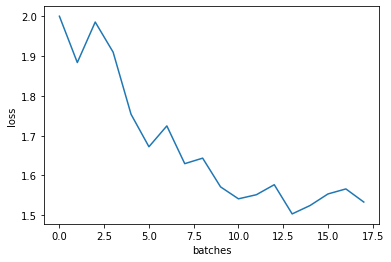

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

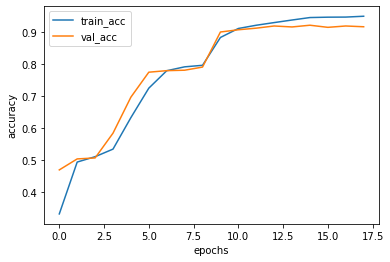

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [ ]:
# retrain last layer to predict mnist and svhn digits
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 

model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(last)
model_new = keras.models.Model(model_new.input, output)

for layer in model_new.layers:
    print(layer, layer.trainable)

model_new.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model_new.summary()

history = model_new.fit(np.concatenate([x_train_mnist, x_train_svhn], axis=0), np.concatenate([y_train_mnist,y_train_svhn],axis=0) , validation_data = (x_val_mnist, y_val_mnist), epochs=10,
    shuffle=True,
    verbose=1)

score = model_new.evaluate(x_test_mnist, y_test_mnist, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f36bfedd048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36bfebe400> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36bfebe0b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36bfeb2828> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f36bcfab860> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36bcfab828> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36bcf9ccf8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36bd00f780> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f36bd00f6a0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f36bd00f898> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f36bfebe160> True
Model: "model_2"
_________________________________________________________________
Layer (type)     

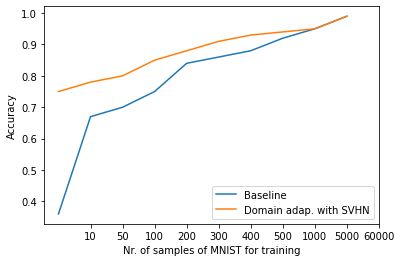

In [ ]:
mnist_baseline_list = [0.36, 0.67, 0.7, 0.75, 0.84, 0.86, 0.88, 0.92, 0.95,0.99]
mnist_svhn_list = [0.75, 0.78, 0.8, 0.85, 0.88, 0.91, 0.93, 0.94, 0.95, 0.99]
samples = ["10", "50", "100", "200", "300", "400", "500", "1000", "5000", "60000"]
samples_ = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.plot(mnist_baseline_list)
plt.plot(mnist_svhn_list)
plt.ylabel('Accuracy')
plt.xlabel('Nr. of samples of MNIST for training')
plt.xticks(samples_, samples)
plt.legend(['Baseline', 'Domain adap. with SVHN'], loc='best')
plt.savefig("mnist_baseline_vs_domainadap")

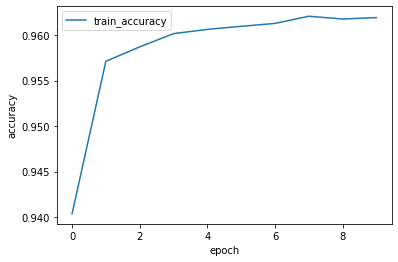

In [ ]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')
plt.show()